In [121]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample

from src.utils import load_data

### Load data

In [122]:
X, y, _ = load_data(impute=True)
print(X.columns)
X = X.values
y = y.values
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 

Index(['youth_pop_5to18', 'commute_priv_vehicle', 'med_hhincome',
       'avg_ann_daily_traffic', 'fragment_index', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')
X-shape: (2095, 35), y-shape: (2095,)


##### Prepare data for model.

In [123]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [124]:
# Get indeces for dividing data into training and test set.
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

In [125]:
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1676
num test: 419


##### Baseline linear regression

In [126]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 8.39306575 12.89845679  7.63540502 11.08336322  7.60040133]
first 5 true values: [ 7 15 18  9 12]
MSE: 42.01973558077289


#### Neural Network

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now split the characteristics into a set of inputs for our linear term, $\textbf{X}'_n$ and a set of inputs for our non-linear term, $\textbf{X}^*_n$, such that
$$
\psi_n = \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

#### PGM
![image info](./neural_net_pgm.jpg)


#### Generative Process

<ol>
    <li> Set hyperparameter $r$. </li>

   <li> Draw non-linear coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $y_n \sim \text{NB}(r, f_{\text{nnet}}(\textbf{X}^*_n))$</li>
    </ol>
</ol>

In [127]:
from torch import nn


class Model(PyroModule):
    def __init__(self, input_shape, output_shape, h1=8, h2=4, r_gamma=2, r_beta=2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_shape, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, input_shape]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([output_shape, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([output_shape]).to_event(1))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.r_gamma = r_gamma
        self.r_beta = r_beta
        
    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        prob_mu = self.sigmoid(x)
        
        r = pyro.sample("r", dist.Gamma(self.r_gamma, self.r_beta).to_event())
        with pyro.plate("data", x.shape[0]):
            
            obs = pyro.sample("obs", dist.NegativeBinomial(r, logits=x), obs=y)
        
        return prob_mu*r/(1-prob_mu) # Average of NB dist


In [128]:
# Prepare data for Pyro model
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [129]:
%%time

# Define guide function.
nn_model = Model(X_train.shape[1], 1)
nn_guide = AutoDiagonalNormal(nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2500

# Setup the optimizer.
optimizer = ClippedAdam({"lr": 0.001})

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step, elbo))
    t.refresh() # to show immediately the update
    

2499 ELBO: 5210.6: 100%|██████████| 2500/2500 [00:49<00:00, 50.23it/s]

CPU times: user 4min 49s, sys: 6.15 s, total: 4min 55s
Wall time: 49.8 s


#### Predict with the model

In [130]:
predictive = Predictive(nn_model, guide=nn_guide, num_samples=5000)
preds = predictive(torch.from_numpy(X_test).float())

y_hat = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

In [131]:
# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 44.11896486393511


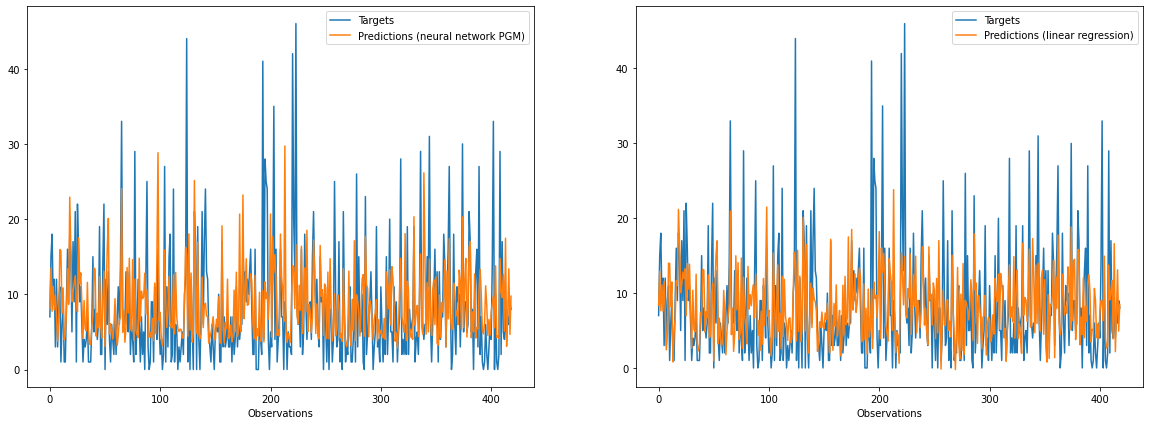

In [132]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (neural network PGM)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

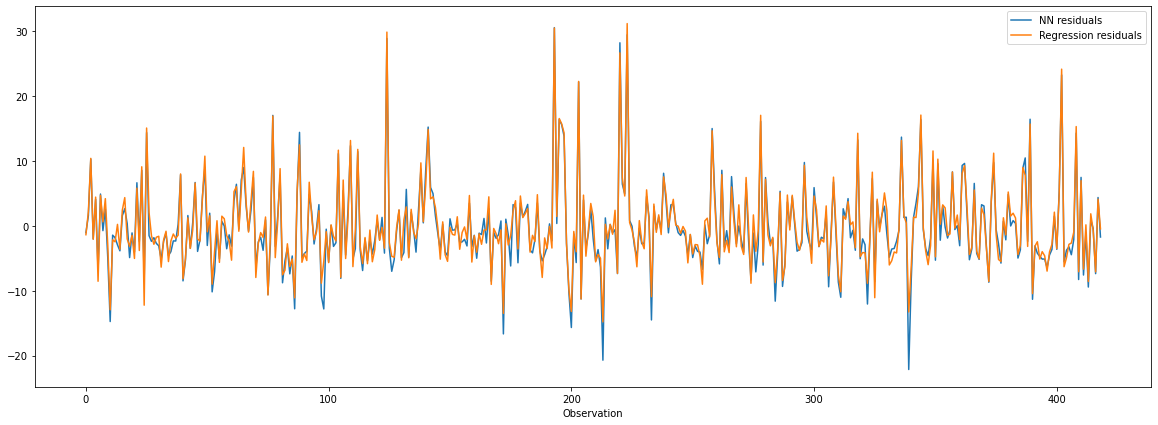

In [133]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="NN residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observation")
plt.plot()